# Empirical Approximation overview

For most models we use sampling MCMC algorithms like Metropolis or NUTS. In pymc3 we got used to store traces of MC samples and then do analysis using them. As new VI interface was implememted it needed a lot of approximation types. 

One of them was so-called *Empirical*. This type of approximation stores particles for SVGD sampler. But there is no difference between independent SVGD particles and MCMC trace. So the idea was pretty simple to understand and realize: make *Empirical* be a bridge between MCMC sampling output and full-fledged VI utils like `apply_replacements` or `sample_node`. For the interface description, see [variational_api_quickstart](variational_api_quickstart.ipynb). Here I will just focus on Emprical and give an overview of specific things for *Empirical* approximation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import numpy as np
import pymc3 as pm
np.random.seed(42)
pm.set_tt_rng(42)

## Multimodal density
Let's recall the problem from [variational_api_quickstart](variational_api_quickstart.ipynb) where we first got a NUTS trace

In [2]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])

with pm.Model() as model:
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd, dtype=theano.config.floatX)
    trace = pm.sample(50000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '26463' (I am process '27017')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 50500/50500 [00:25<00:00, 2015.98it/s]


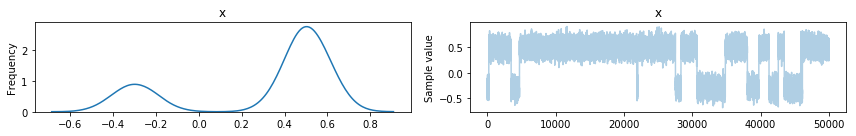

In [3]:
pm.traceplot(trace);

Great. First having a trace we can create `Empirical` approx

In [4]:
print(pm.Empirical.__doc__)

Single Group Full Rank Approximation


In [5]:
with model:
    approx = pm.Empirical(trace)

In [6]:
approx

This type of approximation has it's own underlying storage for samples that is `theano.shared` itself

In [7]:
approx.histogram

histogram

In [8]:
approx.histogram.get_value()[:10]

array([[-0.28495539],
       [-0.27002112],
       [-0.27578667],
       [-0.36169251],
       [-0.43738686],
       [-0.479884  ],
       [-0.3633637 ],
       [-0.31469654],
       [-0.36427262],
       [-0.36479427]])

In [9]:
approx.histogram.get_value().shape

(50000, 1)

It has exactly the same number of samples that you had in trace before. In our particular case it is 50k.  Another thing to notice is thet if you have multitrace with **more than one chain** you'll get much **more samples** stored at once. We flatten all the trace for creating `Empirical`.

This *histogram* is about *how* we store samples. The structure is pretty simple: `(n_samples, n_dim)` The order of these variables is stored internally in the class and in most cases will not be needed for end user

In [10]:
approx.ordering

Sampling from posterior is done uniformly with replacements. Call `approx.sample(1000)` and you'll get again the trace but the order is not determined. There is no way now to reconstruct the underlying trace again with `approx.sample`.

In [11]:
new_trace = approx.sample(50000)

In [12]:
%timeit new_trace = approx.sample(50000)

1.54 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


After sampling function is compiled sampling bacomes really fast

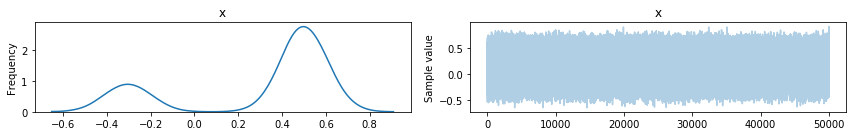

In [13]:
pm.traceplot(new_trace);

You see there is no order any more but reconstructed density is the same.

## 2d density

In [14]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:02<00:00, 677.32it/s]


In [15]:
with model:
    approx = pm.Empirical(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11839eac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118631160>]], dtype=object)

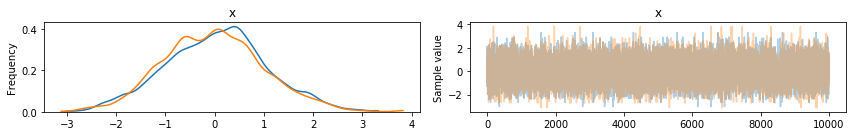

In [16]:
pm.traceplot(approx.sample(10000))

In [17]:
import seaborn as sns

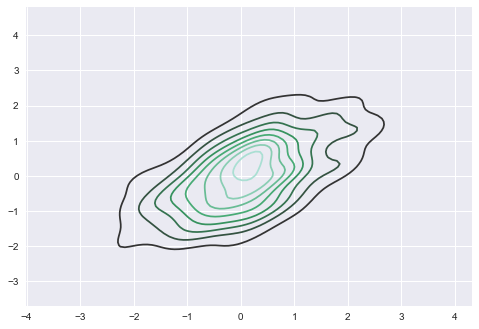

In [18]:
sns.kdeplot(approx.sample(1000)['x'])

Previously we had a `trace_cov` function

In [19]:
with model:
    print(pm.trace_cov(trace))

[[ 1.03635135  0.56102585]
 [ 0.56102585  1.03247922]]


Now we can estimate the same covariance using `Empirical`

In [20]:
print(approx.cov)

Elemwise{true_div,no_inplace}.0


That's a tensor itself

In [21]:
print(approx.cov.eval())

[[ 1.035315    0.56046482]
 [ 0.56046482  1.03144674]]


Estimations are very close and differ due to precision error. We can get the mean in the same way

In [22]:
print(approx.mean.eval())

[ 0.03685694 -0.01467962]
